In [2]:
from src.SimuMM import *
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
pd.options.mode.chained_assignment = None

In [4]:
##############################################################################
#############################  Simulation RESULT LOAD ########################
##############################################################################
run = RunExp()
run = run.loadEXPPickle("./save_data/SimuMM.pickle")

In [13]:
##############################################################################
#############################  DATASET FOR PLOTS #############################
##############################################################################
snsDataSet = pd.DataFrame(np.zeros(((len(run.dict_exp)-1)*len(run.dict_exp[0]["Results"]),7)),
                          columns=["N","PI","M","RMSE","ACC","EXP","Rep"])
h=0
for exp in range(len(run.dict_exp)-1):
    for n in range(len(run.dict_exp[0]["Results"])):
        snsDataSet["N"].iloc[h]  = str(run.dict_exp[exp]["N"])
        if run.dict_exp[exp]["pi"][0] == run.dict_exp[exp]["pi"][1]:
            snsDataSet["PI"].iloc[h] = "equal"
        else:
            snsDataSet["PI"].iloc[h] = "Nequal"
        snsDataSet["M"].iloc[h] = run.dict_exp[exp]["Results"][n]["M"]
        snsDataSet["RMSE"].iloc[h] = round((run.dict_exp[exp]["Results"][n]["RMSE"]),4)
        snsDataSet["EXP"].iloc[h] = exp
        snsDataSet["Rep"].iloc[h] = n
        
        d = np.diag(run.dict_exp[exp]["Results"][n]["CM"][1:,:(run.dict_exp[exp]["Results"][n]["CM"].shape[1]-1)])
#         snsDataSet["ACC"].iloc[h] = round(np.mean(d/run.dict_exp[exp]["Results"][n]["CM"][1:,:(run.dict_exp[exp]["Results"][n]["CM"].shape[1]-1)].sum(axis=1)),4)
        snsDataSet["ACC"].iloc[h] = round(sum(d/sum(run.dict_exp[exp]["Results"][n]["CM"][1:,:(run.dict_exp[exp]["Results"][n]["CM"].shape[1]-1)].sum(axis=1))),4)
        h = h+1

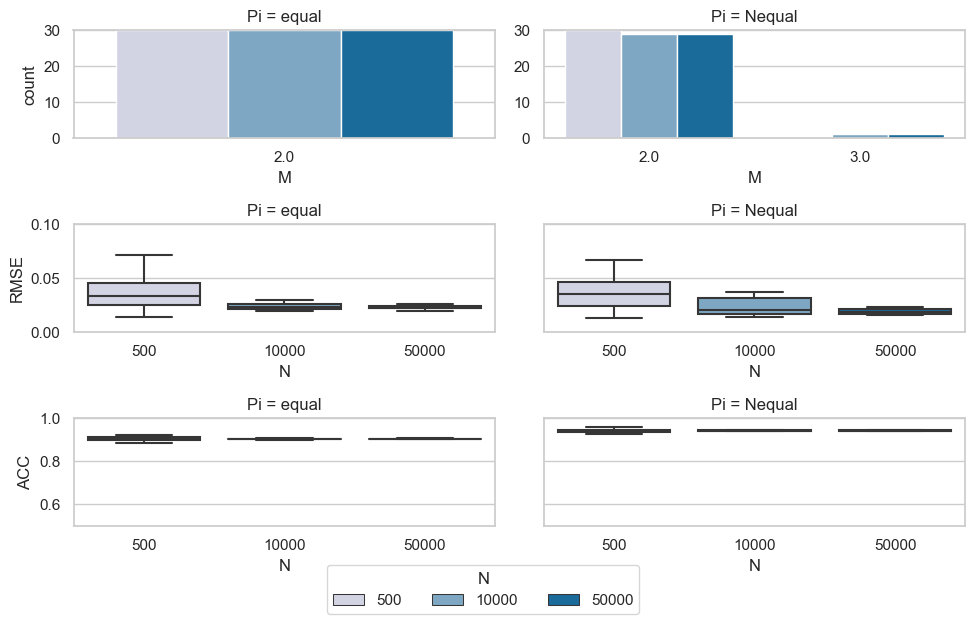

In [11]:
##############################################################################
#############################  SCORES PLOTS ##################################
##############################################################################
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(10, 6))
classe1= list(set(snsDataSet.PI))
classe2= ["equal","Nequal"]
palette = [sns.color_palette("PuBu", 3),sns.color_palette("flare", 3)]

for p1 in range(axes.shape[0]):
    for p2 in range(len(classe2)):
        tmp = snsDataSet[snsDataSet.PI==classe2[p2]]
        if p1 == 0:
            g = sns.countplot(tmp,x='M',hue="N",palette=palette[0],ax=axes[p1,p2])
            axes[p1,p2].legend([],[], frameon=False)
            if p2>0:
                axes[p1,p2].yaxis.label.set_visible(False)
            else:
                axes[p1,p2].legend([],[], frameon=False)
            axes[p1,p2].set(ylim=(0, 30))
        if p1 == 1:
            g = sns.boxplot(tmp,x='N',y='RMSE',hue="N",
                            palette=palette[0],dodge=False,
                            ax=axes[p1,p2],flierprops = dict(markersize = 0))
            axes[p1,p2].legend([],[], frameon=False)
            
#             axes[p1,p2].tick_params(left = False,labelleft=False)
            if p2>0:
                axes[p1,p2].yaxis.label.set_visible(False)
                axes[p1,p2].tick_params(left = False,labelleft=False)
                axes[p1,p2].set(ylim=(0, 0.1))
            else:
                axes[p1,p2].set(ylim=(0, 0.1))
        if p1 == 2:
            g = sns.boxplot(tmp,x='N',y='ACC',hue="N",
                            palette=palette[0],dodge=False,
                            ax=axes[p1,p2],flierprops = dict(markersize = 0))
            axes[p1,p2].legend([],[], frameon=False)
            if p2>0:
                axes[p1,p2].yaxis.label.set_visible(False)
                axes[p1,p2].tick_params(left = False,labelleft=False)
                axes[p1,p2].set(ylim=(0.5, 1))
            else:
                axes[p1,p2].set(ylim=(0.5, 1))
            
        axes[p1,p2].set_title(("Pi = %s")%(classe2[p2]))
handles, labels = axes[p1,p2].get_legend_handles_labels()

lgd = fig.legend(handles,labels,
           bbox_to_anchor=(0.5, -0.05), 
           loc="lower center",
           title="N",
           bbox_transform=fig.transFigure,
           ncol=3)
fig.tight_layout()
fig.savefig("./figure/SimuRes", bbox_extra_artists=(lgd,), bbox_inches='tight')

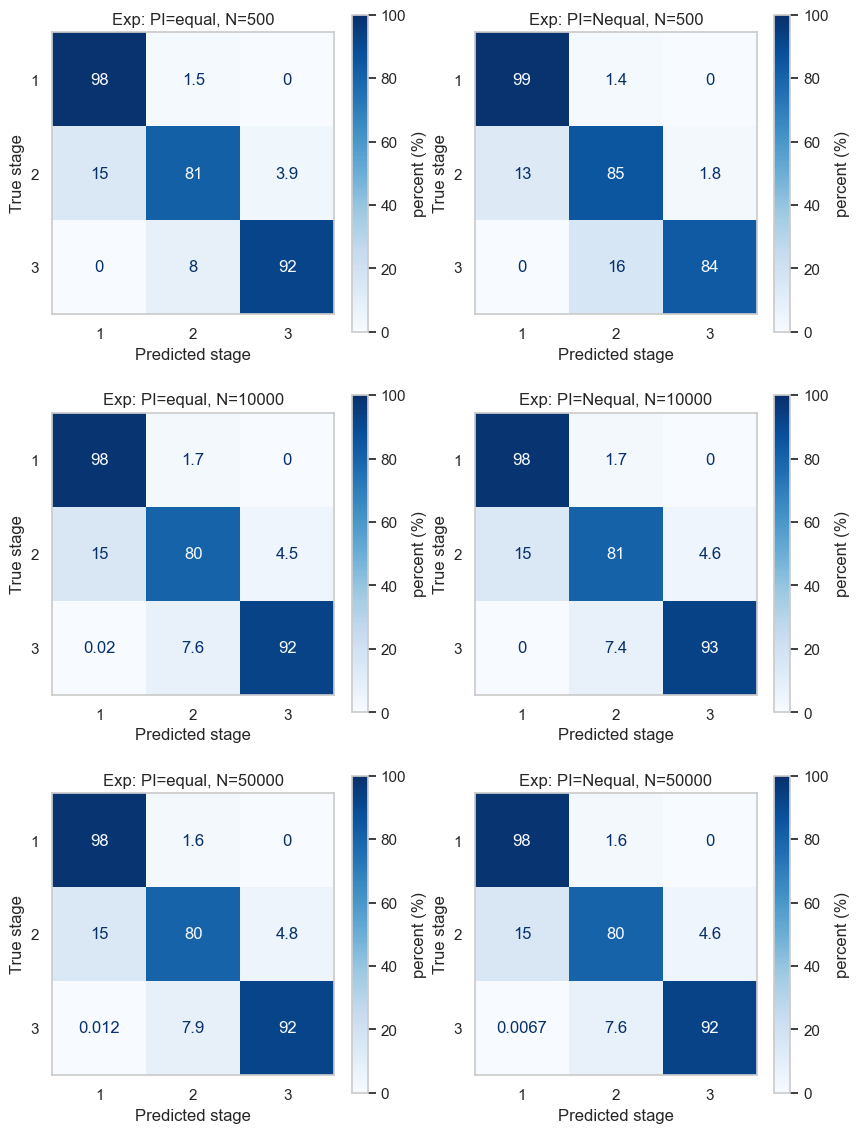

In [10]:
#######################################################################################
############################# CONFUSION MATRIX PLOTS ##################################
#######################################################################################
fig, axes = plt.subplots(3, 2, figsize=(10, 14))
l=0
c=0
classes_name = ["1","2","3"]
for exp in range(len(run.dict_exp)-1):
    N  = str(run.dict_exp[exp]["N"])
    if run.dict_exp[exp]["pi"][0] == run.dict_exp[exp]["pi"][1]:
        PI_ = "equal"
    else:
        PI_ = "Nequal"
    for n in range(len(run.dict_exp[exp]["Results"][n])):
        if n == 0:
            cm = run.dict_exp[exp]["Results"][n]["CM"][1:,:(run.dict_exp[exp]["Results"][n]["CM"].shape[1]-1)]
        else:
            cm = cm + run.dict_exp[exp]["Results"][n]["CM"][1:,:(run.dict_exp[exp]["Results"][n]["CM"].shape[1]-1)]
    
    cm = cm/len(run.dict_exp[exp]["Results"][n])
    cm = cm/cm.sum(axis=1,keepdims=True)*100
    displot = ConfusionMatrixDisplay(confusion_matrix=cm,
                         display_labels=classes_name)
    displot.plot(cmap="Blues",ax=axes[l,c])
    displot.im_.set_clim(0, 100)
    displot.im_.colorbar.set_label('percent (%)')
    axes[l,c].grid(False)
    ytitle = "True stage"
    xtitle = "Predicted stage"
    axes[l,c].set_xlabel(xtitle)
    axes[l,c].set_ylabel(ytitle)
    axes[l,c].set_title("Exp: PI={0}, N={1}".format(PI_,N))
    if PI_ == "equal":
        c=c+1
    else:
        l=l+1
        c=0
fig.savefig("./figure/CMSIMU", bbox_inches='tight')


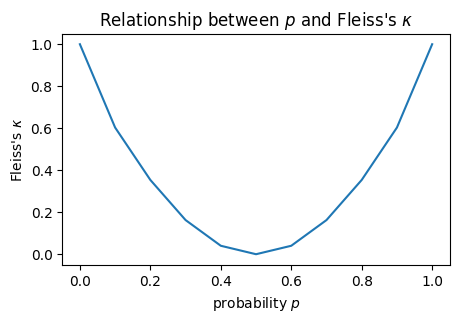

In [9]:
#######################################################################################################################
############################# RELATION BETWEEN CLUSTERS PROBABILITY AND FLEISS KAPPA ##################################
#######################################################################################################################
E=10
n=0.1
seed=12
X = np.arange(0, 1+n, n)
Y = np.arange(0, 1+n, n)

N=100
kappa = []
for i in range(len(X)):
    pi_Z = np.array([[X[i],1-X[i]],[1-Y[i],Y[i]]])
    GenSample = GenMixtSampleFromCatEns(E=E,pi_Z=pi_Z)
    p_Z = np.array([1/2]*2)
    Y_,Z = GenSample.generate(N=N,pi=p_Z,seed=seed,distribution="Categorial")
    X_,Z_X = GenSample.generate(N=N,Z=Z,seed=seed,distribution="Multinomial")
    kappa__ = fleiss_kappa(X_)
    if np.isnan(kappa__):
        kappa__=0
    kappa.append(kappa__)
kappa = np.array(kappa)

fig = plt.figure(figsize=(5,3))
plt.plot(X,kappa)
plt.title("Relationship between $p$ and Fleiss's $\kappa$")
plt.ylabel("Fleiss's $\kappa$")
plt.xlabel("probability $p$")
fig.savefig("./figure/RELATIONFLEISS", bbox_inches='tight')